In [1]:
# util for SFG DRO
import torch
from sklearn.kernel_approximation import RBFSampler
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# This function builds the model for one-vs-all classification
def buildModel(task=None, method=None,n_hidden=100, device=None, loss_reduction='mean'):
    n_output = 1  # Only one output node for one-vs-all classification
    loss_erm = nn.BCEWithLogitsLoss(reduction=loss_reduction)  # Binary Cross-Entropy Loss
    
    # Defining the model architecture
    modelDecision = nn.Sequential(
        Flatten(), 
        nn.Linear(784, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_output)
    ).to(device)
    
    return modelDecision, loss_erm

def computeErr(yp, y,task=None,shuffle_test=False):
    predictions = (yp > 0).float()  # Converting model outputs to binary predictions
    err = (predictions != y).float().mean().item()  # Calculating the error rate
    return err





In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def cifar10Data(task='one_vs_all', class_num=0, batch_size=100, shuffle_test=False):
    if class_num < 0 or class_num > 9:
        raise ValueError("class_num should be between 0 and 9")

    # Applying necessary transforms on the CIFAR-10 data including grayscale and resize
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Fetching CIFAR-10 data
    cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    if task == 'binary':
        train_idx = np.where((np.array(cifar10_train.targets) == 0) | (np.array(cifar10_train.targets) == 1))
        cifar10_train.targets = np.array(cifar10_train.targets)[train_idx]
        cifar10_train.data = cifar10_train.data[train_idx]

        test_idx = np.where((np.array(cifar10_test.targets) == 0) | (np.array(cifar10_test.targets) == 1))
        cifar10_test.targets = np.array(cifar10_test.targets)[test_idx]
        cifar10_test.data = cifar10_test.data[test_idx]
    elif task == 'one_vs_all':
        cifar10_train.targets = (np.array(cifar10_train.targets) == class_num).astype(float)
        cifar10_test.targets = (np.array(cifar10_test.targets) == class_num).astype(float)
    elif task == 'multi':
        # For multi-class classification, no need to modify the labels
        pass
    else:
        raise NotImplementedError

    train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=shuffle_test)

    return train_loader, test_loader




In [4]:
def apply_gd(x, step_gamma=0.1):
    if x.grad is None:
        return x
    xnew = x - step_gamma * x.grad.detach()
    x.grad.data.zero_()
    return xnew


# a general loss function
def loss_general_se(output, target):
    return torch.sum((output - target) ** 2, dim=1).reshape(-1, 1)


def sample_zeta(X, y, zeta_sample_method=None, loss_erm=None, modelDecision=None, n_sample_zeta=1, epsilon_attack=0.0, learn_task=None, F=None):
    Z = None
    yperturb = None

    for _ in range(n_sample_zeta):
        delta = zeta_sample_method(loss_erm, modelDecision, X, y, randomize=True, epsilon=epsilon_attack,
                                   alpha=0.01, num_iter=20, task=learn_task, mklF=F)  # used with the new pgd
        # delta = attack(loss_erm, modelDecision, X, y, randomize=True, epsilon=1.0, alpha=0.01, num_iter=20, task=learn_task, rkhsF=F) # used with the new pgd

        Zperturb = X + delta
        if Z is not None:  # also penalize the original loss at unperturbed data
            Z = torch.cat((Zperturb, Z))  # cat new perturb Z with the old
            yperturb = torch.cat((yperturb, y))
        else:
            Z = Zperturb
            yperturb = y

    return Z, yperturb

In [5]:
def sfg_train_step(X=None, y=None, just_rand=None, loss_erm=None, modelDecision=None, n_sample_zeta=None, epsilon_attack=None,
                   learn_task=None, F=None, epsilon=None, stat_plot=None, i_decay_csa=None, is_step_const=None,
                   model_class=None, modelSWA=None):
    Z, y = sample_zeta(X, y, zeta_sample_method=just_rand, loss_erm=loss_erm,
                       modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                       epsilon_attack=epsilon_attack, learn_task=learn_task, F=F)
    yp = evalutateErmModel(modelDecision, Z,
                           task=learn_task)  # use original model in ERM to run thru data X
    # kdro surrogate loss
    f_emp = torch.mean(F(X, fit=True))  # emp loss under emp loss
    # '''KDRO obj'''
    obj = f_emp + epsilon * F.norm()  # obj of the optimization problem
    #  original loss l eval on z
    loss_emp = loss_erm(yp, y).reshape(-1, 1)
    assert loss_emp.shape == F(Z).shape
    cons_sip = loss_emp - F(Z)  # constraint function of SIP. G(th, zeta)
    partial_moment = 1
    if partial_moment:  # use functional constr: E h(l-f) = 0
        max_cons_g = torch.mean(torch.nn.functional.relu(cons_sip))
    else:
        max_cons_g, id_max = torch.max(cons_sip, 0)  # max of violation across all samples zeta
    # bookeeping
    stat_plot["max_cons_violation"].append(max_cons_g.data.detach())
    stat_plot["obj"].append(obj.data.detach())

    '''CSA - SGD step size'''
    # threshold
    threshold_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    # threshold_csa = 0.01 # constant step
    # step size
    if is_step_const:
        step_csa = 0.01
    else:
        step_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    i_decay_csa += 1
    # %% update dec var: th, f0, f
    # zero gradient before backward
    try:
        for w in modelDecision.parameters(): w.grad.data.zero_()
        for w in F.model.parameters(): w.grad.data.zero_()
    except:
        pass
    if max_cons_g <= threshold_csa:  # if constr satisfied
        obj.backward()
        # there is no th update since obj doens't have th in it

        # %% if cons. satisfied, polyak averaging to keep track of average
        if model_class == 'mlp':
            modelSWA.update_parameters(modelDecision)  # model with averaged weights
            # pass
        else:
            raise NotImplementedError

    else:  # cons violation
        if partial_moment:
            max_cons_g.backward()  # diff this:  E h(l-f)
        else:
            cons_sip[id_max].backward()

        # update model var
        if model_class == 'mlp':
            for weight in modelDecision.parameters():
                weight.data = apply_gd(weight, step_csa)
        else:
            raise NotImplementedError
    # update f0, weights of f
    for weight in F.model.parameters():
        weight.data = apply_gd(weight, step_csa)
    return i_decay_csa, stat_plot


In [6]:
def run_test(test_loader, modelERM, loss_erm, loaded, attack_function=None, attack_range=None, task=None, n_test=100, device=None):
    D = {'err': [], 'attack': [], 'sig': []}
    for attack_strength in attack_range:
        i_test = 0

        err_this_attack = []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if task=='binary' or task=='one_vs_all':
                y = y.float()
            i_test += 1
            if i_test > n_test:
                break

            delta = attack_function(loss_erm, modelERM, X, y, attack_strength, task=task)

            # evaluate attack
            #         plt.figure()
            yp = evalutateErmModel(loaded['model'], X + delta, task=task)
            err_kdro = computeErr(yp, y, task=task)

            err_this_attack.append(deepcopy(err_kdro))

        # for each attack, compute average
        D['err'].append(np.mean(err_this_attack))
        D['sig'].append(np.std(err_this_attack))
        D['attack'].append(attack_strength)

    D['n_run'] = len(err_this_attack)  # total number of runs
    D['eps_dro'] = loaded['epsilon']
    D['is_erm'] = loaded['is_erm']
    try:
        D['is_pgd'] = loaded['is_pgd']
    except:
        pass

    D['task'] = task

    return D



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as Fa

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MKLfunction(nn.Module):
    def __init__(self, input_shape, model=None, gamma=None, degree=3, coef0=1, kernel_list=None):
        super(MKLfunction, self).__init__()
        self.model = model
        self.input_shape = input_shape
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
        self.flatten = Flatten()  # Instantiate the Flatten module
        self.kernel_list = kernel_list or [self.rbf_kernel_torch, self.polynomial_kernel_torch]
        self.kernel_weights = nn.Parameter(torch.ones(len(self.kernel_list)), requires_grad=True)

    def rbf_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        gamma = self.gamma if self.gamma is not None else 1.0 / X.size(1)
        
        sq_norms_X = torch.sum(X**2, dim=1)
        sq_norms_Y = torch.sum(Y**2, dim=1)
        cross_products = torch.mm(X, Y.t())
        distances = sq_norms_X[:, None] + sq_norms_Y[None, :] - 2 * cross_products
        return torch.exp(-gamma * distances)

    def polynomial_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        products = torch.mm(X, Y.t())
        return (products + self.coef0)**self.degree

    def compute_combined_kernel(self, X):
        X_tensor = X.clone().detach().requires_grad_(True)
        kernel_matrices = [k(X_tensor) for k in self.kernel_list]
        normalized_weights = Fa.softmax(self.kernel_weights, dim=0)
        K_combined = sum(w * km for w, km in zip(normalized_weights, kernel_matrices))
        return K_combined

    def forward(self, X, fit=False):
        K_combined = self.compute_combined_kernel(X)
        
        # Ensure that the model is correctly defined for the shape of K_combined
        if self.model is None or self.model[1].in_features != K_combined.shape[1]:
            self.model = nn.Sequential(Flatten(), nn.Linear(K_combined.shape[1], 1, bias=True))

        mklF = self.model(K_combined)
        return mklF

    def norm(self):
        return torch.norm(self.kernel_weights)



In [8]:



def evalutateErmModel(modelDecision, X, task=None):
    yp = modelDecision(X.view(X.shape[0], -1)).squeeze()  # No need for indexing in one-vs-all
    return yp




In [9]:
def pgd_linf(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = loss_attack(evalutateErmModel(model, X + delta, task=task), y)
        if loss.numel() != 1:  # This is to check if the tensor is not a scalar
            loss = loss.sum()  # Or use mean(), depending on your specific requirements
        loss.backward()

        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    # for w in model.parameters(): w.grad.data.zero_()
        # for w in rkhsF.model.parameters(): w.grad.data.zero_()
    return delta.detach()


def just_rand(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None, **kwargs):
    """ just use random noises to sample new samples"""
    delta = torch.rand_like(X, requires_grad=False)
    delta.data = 2* (delta.data - 0.5) * epsilon

    return delta.detach()

In [10]:
# params
n_epoch_gd = 10# how many epochs of SFG to run
learn_task = 'one_vs_all'
mini_batch = 20 
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = cifar10Data(task=learn_task, batch_size=mini_batch)
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)


X_initial, y_initial = next(iter(train_loader))
X_initial = X_initial.requires_grad_(True).to(device)

# Define the model to be used within MKLfunction
input_features = X_initial.shape[1] * X_initial.shape[2] * X_initial.shape[3]
mkl_model = nn.Sequential(
    Flatten(),
    nn.Linear(input_features, 96),  # Adjust the output features as needed
    nn.ReLU(),
    nn.Linear(96, 1)
).to(device)

# Instantiate the MKLfunction with the newly defined model
F = MKLfunction(X_initial.shape, model=mkl_model)

# Bookkeeping
stat_plot = {"max_cons_violation": [], "obj": []}

Files already downloaded and verified
Files already downloaded and verified


In [11]:
from tqdm import tqdm

print("=========Training SFG DRO=========")

i_decay_csa = 0  # counter for threshold decay

# Wrapping the range function with tqdm to get progress bar for epochs
for i_epoch in tqdm(range(n_epoch_gd), desc="Epochs"):
    # Wrapping the train_loader with tqdm to get progress bar for batches
    for X, y in tqdm(train_loader, desc="Batches", leave=False):
        X, y = X.to(device), y.to(device)
        if learn_task=='binary' or learn_task=='one_vs_all':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch, '/', n_epoch_gd)

print("=========Training Finished=========")

=========Training SFG DRO=========


Batches:   5%|▌         | 126/2500 [08:09<2:31:10,  3.82s/it]


Batches:  10%|█         | 252/2500 [16:08<2:45:38,  4.42s/it]


Batches:  15%|█▌        | 378/2500 [24:37<2:34:40,  4.37s/it]


Batches:  20%|██        | 504/2500 [33:58<2:30:34,  4.53s/it]


Batches:  25%|██▌       | 630/2500 [45:44<2:59:16,  5.75s/it]


Batches:  30%|███       | 756/2500 [55:17<1:52:04,  3.86s/it]


Batches:  35%|███▌      | 880/2500 [1:04:08<1:55:53,  4.29s/it]


Batches:  40%|████      | 1002/2500 [1:14:14<1:52:18,  4.50s/it]


Batches:  45%|████▍     | 1122/2500 [1:25:56<2:25:41,  6.34s/it]


Batches:  50%|████▉     | 1242/2500 [1:37:02<2:02:42,  5.85s/it]


Batches:  54%|█████▍    | 1362/2500 [1:47:36<1:48:45,  5.73s/it]


Batches:  59%|█████▉    | 1482/2500 [1:57:07<1:11:23,  4.21s/it]


Batches:  64%|██████▍   | 1602/2500 [2:05:56<1:12:40,  4.86s/it]


Batches:  69%|██████▉   | 1723/2500 [2:15:25<1:10:11,  5.42s/it]


Batches:  74%|███████▍  | 1844/2500 [2:27:03<52:42,  4.82s/it]


Batches:  79%|███████▊  | 1967/2500 [2:38:07<49:01,  5.52s/it]


Batches:  84%|████████▎ | 2091/2500 [2:47:02<26:17,  3.86s/it]


Batches:  89%|████████▊ | 2215/2500 [2:57:19<29:34,  6.23s/it]


Batches:  94%|█████████▎| 2339/2500 [3:09:07<17:49,  6.64s/it]


Batches:  99%|█████████▊| 2463/2500 [3:20:33<03:19,  5.38s/it]


Epochs:  10%|█         | 1/10 [3:23:43<30:33:31, 12223.53s/it]

epoch: 0 / 10



Batches:   5%|▌         | 126/2500 [10:35<3:13:37,  4.89s/it]


Batches:  10%|█         | 252/2500 [21:37<3:18:48,  5.31s/it]


Batches:  15%|█▌        | 378/2500 [32:12<3:11:00,  5.40s/it]


Batches:  20%|██        | 504/2500 [42:23<2:51:53,  5.17s/it]


Batches:  25%|██▌       | 630/2500 [53:07<2:32:45,  4.90s/it]


Batches:  30%|███       | 754/2500 [1:03:57<2:24:19,  4.96s/it]


Batches:  35%|███▌      | 876/2500 [1:13:59<1:52:57,  4.17s/it]


Batches:  40%|███▉      | 998/2500 [1:22:52<1:48:32,  4.34s/it]


Batches:  45%|████▍     | 1118/2500 [1:30:38<1:27:18,  3.79s/it]


Batches:  50%|████▉     | 1238/2500 [1:39:23<1:29:42,  4.26s/it]


Batches:  54%|█████▍    | 1358/2500 [1:50:44<1:58:36,  6.23s/it]


Batches:  59%|█████▉    | 1478/2500 [2:03:35<1:09:58,  4.11s/it]


Batches:  64%|██████▍   | 1598/2500 [2:14:20<1:49:57,  7.31s/it]


Batches:  69%|██████▊   | 1718/2500 [2:25:41<1:06:55,  5.13s/it]


Batches:  74%|███████▎  | 1841/2500 [2:35:00<47:41,  4.34s/it]


Batches:  79%|███████▊  | 1965/2500 [2:44:18<36:04,  4.05s/it]


Batches:  84%|████████▎ | 2089/2500 [2:56:17<45:54,  6.70s/it]


Batches:  89%|████████▊ | 2213/2500 [3:08:42<30:45,  6.43s/it]


Batches:  93%|█████████▎| 2337/2500 [3:19:16<11:48,  4.35s/it]


Batches:  98%|█████████▊| 2461/2500 [3:31:36<05:08,  7.90s/it]


Epochs:  20%|██        | 2/10 [6:59:43<28:07:33, 12656.65s/it]

epoch: 1 / 10



Batches:   5%|▌         | 126/2500 [09:33<2:39:55,  4.04s/it]


Batches:  10%|█         | 252/2500 [19:23<3:48:40,  6.10s/it]


Batches:  15%|█▌        | 378/2500 [32:57<2:53:40,  4.91s/it]


Batches:  20%|██        | 504/2500 [42:52<2:34:44,  4.65s/it]


Batches:  25%|██▌       | 630/2500 [52:33<2:36:06,  5.01s/it]


Batches:  30%|███       | 755/2500 [1:02:52<2:33:55,  5.29s/it]


Batches:  35%|███▌      | 877/2500 [1:13:09<1:39:00,  3.66s/it]


Batches:  40%|███▉      | 999/2500 [1:21:41<2:10:39,  5.22s/it]


Batches:  45%|████▍     | 1119/2500 [1:30:33<1:48:47,  4.73s/it]


Batches:  50%|████▉     | 1239/2500 [1:39:56<1:35:26,  4.54s/it]


Batches:  54%|█████▍    | 1359/2500 [1:49:02<1:30:04,  4.74s/it]


Batches:  59%|█████▉    | 1479/2500 [1:58:56<2:24:13,  8.48s/it]


Batches:  64%|██████▍   | 1599/2500 [2:08:57<1:07:48,  4.52s/it]


Batches:  69%|██████▉   | 1720/2500 [2:18:21<50:45,  3.90s/it]


Batches:  74%|███████▎  | 1841/2500 [2:29:13<1:12:03,  6.56s/it]


Batches:  79%|███████▊  | 1964/2500 [2:39:42<39:26,  4.42s/it]


Batches:  84%|████████▎ | 2088/2500 [2:49:05<33:42,  4.91s/it]


Batches:  88%|████████▊ | 2212/2500 [3:02:49<33:41,  7.02s/it]


Batches:  93%|█████████▎| 2336/2500 [3:13:01<16:59,  6.22s/it]


Batches:  98%|█████████▊| 2460/2500 [3:23:11<02:36,  3.92s/it]


Epochs:  30%|███       | 3/10 [10:25:48<24:21:05, 12523.58s/it][A

epoch: 2 / 10



Batches:   5%|▌         | 126/2500 [13:21<3:20:57,  5.08s/it]


Batches:  10%|█         | 252/2500 [23:59<3:14:18,  5.19s/it]


Batches:  15%|█▌        | 378/2500 [33:14<2:11:34,  3.72s/it]


Batches:  20%|██        | 504/2500 [41:58<2:43:13,  4.91s/it]


Batches:  25%|██▌       | 630/2500 [51:31<2:03:14,  3.95s/it]


Batches:  30%|███       | 754/2500 [1:04:13<4:04:54,  8.42s/it]


Batches:  35%|███▌      | 876/2500 [1:14:09<2:22:19,  5.26s/it]


Batches:  40%|███▉      | 998/2500 [1:22:20<1:40:52,  4.03s/it]


Batches:  45%|████▍     | 1118/2500 [1:30:31<1:24:00,  3.65s/it]


Batches:  50%|████▉     | 1238/2500 [1:40:49<1:34:45,  4.51s/it]


Batches:  54%|█████▍    | 1358/2500 [1:49:46<2:07:33,  6.70s/it]


Batches:  59%|█████▉    | 1478/2500 [2:01:25<1:29:06,  5.23s/it]


Batches:  64%|██████▍   | 1598/2500 [2:14:04<1:15:36,  5.03s/it]


Batches:  69%|██████▊   | 1718/2500 [2:25:13<1:20:10,  6.15s/it]


Batches:  74%|███████▎  | 1839/2500 [2:36:24<1:07:45,  6.15s/it]


Batches:  78%|███████▊  | 1961/2500 [2:48:09<43:32,  4.85s/it]


Batches:  83%|████████▎ | 2085/2500 [2:58:05<39:15,  5.68s/it]


Batches:  88%|████████▊ | 2209/2500 [3:10:31<32:20,  6.67s/it]


Batches:  93%|█████████▎| 2333/2500 [3:20:10<18:49,  6.76s/it]


Batches:  98%|█████████▊| 2457/2500 [3:29:37<02:50,  3.96s/it]


Epochs:  40%|████      | 4/10 [13:58:38<21:02:04, 12620.80s/it][A

epoch: 3 / 10



Batches:   5%|▌         | 126/2500 [08:28<2:29:46,  3.79s/it]


Batches:  10%|█         | 252/2500 [17:53<2:27:33,  3.94s/it]


Batches:  15%|█▌        | 378/2500 [26:02<1:51:45,  3.16s/it]


Batches:  20%|██        | 504/2500 [35:12<2:11:08,  3.94s/it]


Batches:  25%|██▌       | 630/2500 [44:20<2:06:12,  4.05s/it]


Batches:  30%|███       | 756/2500 [53:25<1:56:29,  4.01s/it]


Batches:  35%|███▌      | 881/2500 [1:02:13<2:03:26,  4.57s/it]


Batches:  40%|████      | 1003/2500 [1:10:45<1:37:02,  3.89s/it]


Batches:  45%|████▍     | 1123/2500 [1:18:40<1:23:45,  3.65s/it]


Batches:  50%|████▉     | 1243/2500 [1:26:56<1:21:01,  3.87s/it]


Batches:  55%|█████▍    | 1363/2500 [1:35:18<1:14:32,  3.93s/it]


Batches:  59%|█████▉    | 1483/2500 [1:43:33<1:16:21,  4.50s/it]


Batches:  64%|██████▍   | 1603/2500 [1:52:28<1:10:37,  4.72s/it]


Batches:  69%|██████▉   | 1725/2500 [2:01:03<56:54,  4.41s/it]


Batches:  74%|███████▍  | 1848/2500 [2:09:49<40:04,  3.69s/it]


Batches:  79%|███████▉  | 1972/2500 [2:18:04<39:43,  4.52s/it]


Batches:  84%|████████▍ | 2096/2500 [2:26:27<25:11,  3.74s/it]


Batches:  89%|████████▉ | 2220/2500 [2:35:25<15:46,  3.38s/it]


Batches:  94%|█████████▍| 2344/2500 [2:44:21<10:42,  4.12s/it]


Batches:  99%|█████████▊| 2468/2500 [2:53:06<01:53,  3.53s/it]


Epochs:  50%|█████     | 5/10 [16:54:04<16:28:47, 11865.49s/it][A

epoch: 4 / 10



Batches:   5%|▌         | 126/2500 [09:03<2:51:09,  4.33s/it]


Batches:  10%|█         | 252/2500 [18:16<2:45:15,  4.41s/it]


Batches:  15%|█▌        | 378/2500 [27:41<2:48:44,  4.77s/it]


Batches:  20%|██        | 504/2500 [36:49<2:21:53,  4.27s/it]


Batches:  25%|██▌       | 630/2500 [45:42<2:29:34,  4.80s/it]


Batches:  30%|███       | 756/2500 [53:43<1:43:32,  3.56s/it]


Batches:  35%|███▌      | 880/2500 [1:02:42<2:10:13,  4.82s/it]


Batches:  40%|████      | 1002/2500 [1:11:14<1:46:40,  4.27s/it]


Batches:  45%|████▍     | 1122/2500 [1:20:48<1:49:22,  4.76s/it]


Batches:  50%|████▉     | 1242/2500 [1:29:19<1:30:03,  4.30s/it]


Batches:  54%|█████▍    | 1362/2500 [1:37:18<1:09:19,  3.66s/it]


Batches:  59%|█████▉    | 1482/2500 [1:45:49<1:21:08,  4.78s/it]


Batches:  64%|██████▍   | 1602/2500 [1:54:00<57:01,  3.81s/it]


Batches:  69%|██████▉   | 1725/2500 [2:02:02<54:53,  4.25s/it]


Batches:  74%|███████▍  | 1848/2500 [2:11:29<45:48,  4.21s/it]


Batches:  79%|███████▉  | 1972/2500 [2:20:45<44:20,  5.04s/it]


Batches:  84%|████████▍ | 2096/2500 [2:29:36<20:14,  3.01s/it]


Batches:  89%|████████▉ | 2220/2500 [2:37:51<19:51,  4.25s/it]


Batches:  94%|█████████▍| 2344/2500 [2:45:53<11:06,  4.27s/it]


Batches:  99%|█████████▊| 2468/2500 [2:53:44<01:49,  3.42s/it]


Epochs:  60%|██████    | 6/10 [19:49:58<12:41:18, 11419.66s/it][A

epoch: 5 / 10



Batches:   5%|▌         | 126/2500 [08:06<2:32:07,  3.84s/it]


Batches:  10%|█         | 252/2500 [16:03<2:21:01,  3.76s/it]


Batches:  15%|█▌        | 378/2500 [24:45<2:27:30,  4.17s/it]


Batches:  20%|██        | 504/2500 [32:40<2:09:28,  3.89s/it]


Batches:  25%|██▌       | 630/2500 [40:34<1:59:59,  3.85s/it]


Batches:  30%|███       | 756/2500 [48:27<1:43:32,  3.56s/it]


Batches:  35%|███▌      | 882/2500 [56:25<1:58:09,  4.38s/it]


Batches:  40%|████      | 1005/2500 [1:03:59<1:38:58,  3.97s/it]


Batches:  45%|████▌     | 1125/2500 [1:11:48<1:38:15,  4.29s/it]


Batches:  50%|████▉     | 1245/2500 [1:19:46<1:31:06,  4.36s/it]


Batches:  55%|█████▍    | 1365/2500 [1:28:42<1:33:14,  4.93s/it]


Batches:  59%|█████▉    | 1485/2500 [1:36:37<1:08:12,  4.03s/it]


Batches:  64%|██████▍   | 1605/2500 [1:44:30<1:11:39,  4.80s/it]


Batches:  69%|██████▉   | 1726/2500 [1:53:28<57:27,  4.45s/it]


Batches:  74%|███████▍  | 1849/2500 [2:02:34<51:42,  4.77s/it]


Batches:  79%|███████▉  | 1973/2500 [2:11:29<33:06,  3.77s/it]


Batches:  84%|████████▍ | 2097/2500 [2:20:20<30:09,  4.49s/it]


Batches:  89%|████████▉ | 2221/2500 [2:28:23<18:48,  4.05s/it]


Batches:  94%|█████████▍| 2345/2500 [2:36:08<12:08,  4.70s/it]


Batches:  99%|█████████▉| 2469/2500 [2:44:44<02:06,  4.07s/it]


Epochs:  70%|███████   | 7/10 [22:36:36<9:07:44, 10954.75s/it] [A

epoch: 6 / 10



Batches:   5%|▌         | 126/2500 [08:11<2:40:03,  4.05s/it]


Batches:  10%|█         | 252/2500 [16:18<2:26:52,  3.92s/it]


Batches:  15%|█▌        | 378/2500 [24:46<1:59:02,  3.37s/it]


Batches:  20%|██        | 504/2500 [32:40<2:16:02,  4.09s/it]


Batches:  25%|██▌       | 630/2500 [40:38<1:59:51,  3.85s/it]


Batches:  30%|███       | 756/2500 [48:35<1:56:19,  4.00s/it]


Batches:  35%|███▌      | 882/2500 [57:44<1:53:00,  4.19s/it]


Batches:  40%|████      | 1005/2500 [1:06:52<2:03:40,  4.96s/it]


Batches:  45%|████▌     | 1125/2500 [1:14:53<1:29:33,  3.91s/it]


Batches:  50%|████▉     | 1245/2500 [1:22:21<1:21:32,  3.90s/it]


Batches:  55%|█████▍    | 1365/2500 [1:30:03<1:05:44,  3.48s/it]


Batches:  59%|█████▉    | 1485/2500 [1:37:30<58:14,  3.44s/it]  


Batches:  64%|██████▍   | 1606/2500 [1:45:35<55:43,  3.74s/it]


Batches:  69%|██████▉   | 1729/2500 [1:53:51<53:55,  4.20s/it]


Batches:  74%|███████▍  | 1852/2500 [2:02:36<40:11,  3.72s/it]


Batches:  79%|███████▉  | 1976/2500 [2:10:33<34:41,  3.97s/it]


Batches:  84%|████████▍ | 2100/2500 [2:18:26<24:54,  3.74s/it]


Batches:  89%|████████▉ | 2224/2500 [2:26:48<20:09,  4.38s/it]


Batches:  94%|█████████▍| 2348/2500 [2:35:43<10:41,  4.22s/it]


Batches:  99%|█████████▉| 2472/2500 [2:44:50<02:03,  4.40s/it]


Epochs:  80%|████████  | 8/10 [25:23:24<5:55:06, 10653.47s/it]

epoch: 7 / 10



Batches:   5%|▌         | 126/2500 [08:06<2:40:25,  4.05s/it]


Batches:  10%|█         | 252/2500 [16:15<2:34:47,  4.13s/it]


Batches:  15%|█▌        | 378/2500 [24:46<2:41:31,  4.57s/it]


Batches:  20%|██        | 504/2500 [33:33<2:12:32,  3.98s/it]


Batches:  25%|██▌       | 630/2500 [42:12<2:23:58,  4.62s/it]


Batches:  30%|███       | 756/2500 [51:31<2:13:30,  4.59s/it]


Batches:  35%|███▌      | 882/2500 [1:00:02<1:43:34,  3.84s/it]


Batches:  40%|████      | 1004/2500 [1:08:33<1:52:27,  4.51s/it]


Batches:  45%|████▍     | 1124/2500 [1:17:16<1:22:06,  3.58s/it]


Batches:  50%|████▉     | 1244/2500 [1:25:01<1:18:54,  3.77s/it]


Batches:  55%|█████▍    | 1364/2500 [1:32:42<1:10:26,  3.72s/it]


Batches:  59%|█████▉    | 1484/2500 [1:40:26<1:03:59,  3.78s/it]


Batches:  64%|██████▍   | 1604/2500 [1:49:18<59:23,  3.98s/it]  


Batches:  69%|██████▉   | 1726/2500 [1:57:37<57:19,  4.44s/it]  


Batches:  74%|███████▍  | 1850/2500 [2:05:55<53:43,  4.96s/it]


Batches:  79%|███████▉  | 1974/2500 [2:15:04<37:51,  4.32s/it]


Batches:  84%|████████▍ | 2098/2500 [2:24:15<30:56,  4.62s/it]


Batches:  89%|████████▉ | 2222/2500 [2:33:11<17:37,  3.81s/it]


Batches:  94%|█████████▍| 2346/2500 [2:41:13<10:41,  4.17s/it]


Batches:  99%|█████████▉| 2470/2500 [2:49:52<02:37,  5.24s/it]


Epochs:  90%|█████████ | 9/10 [28:15:40<2:55:54, 10554.24s/it]

epoch: 8 / 10



Batches:   5%|▌         | 126/2500 [08:04<2:55:33,  4.44s/it]


Batches:  10%|█         | 252/2500 [17:03<3:11:17,  5.11s/it]


Batches:  15%|█▌        | 378/2500 [25:19<2:33:57,  4.35s/it]


Batches:  20%|██        | 504/2500 [33:45<2:16:58,  4.12s/it]


Batches:  25%|██▌       | 630/2500 [42:15<2:18:51,  4.46s/it]


Batches:  30%|███       | 756/2500 [50:48<1:52:27,  3.87s/it]


Batches:  35%|███▌      | 882/2500 [59:12<1:48:02,  4.01s/it]


Batches:  40%|████      | 1004/2500 [1:07:18<1:45:12,  4.22s/it]


Batches:  45%|████▍     | 1124/2500 [1:15:10<1:33:50,  4.09s/it]


Batches:  50%|████▉     | 1244/2500 [1:23:23<1:33:25,  4.46s/it]


Batches:  55%|█████▍    | 1364/2500 [1:32:29<1:32:59,  4.91s/it]


Batches:  59%|█████▉    | 1484/2500 [1:43:34<1:29:41,  5.30s/it]


Batches:  64%|██████▍   | 1604/2500 [1:53:15<1:11:37,  4.80s/it]


Batches:  69%|██████▉   | 1724/2500 [2:03:30<1:21:46,  6.32s/it]


Batches:  74%|███████▍  | 1844/2500 [2:15:49<1:09:34,  6.36s/it]


Batches:  79%|███████▊  | 1966/2500 [2:27:58<37:13,  4.18s/it]


Batches:  84%|████████▎ | 2090/2500 [2:36:26<24:25,  3.58s/it]


Batches:  89%|████████▊ | 2214/2500 [2:46:36<22:51,  4.79s/it]


Batches:  94%|█████████▎| 2338/2500 [2:58:03<11:38,  4.31s/it]


Batches:  98%|█████████▊| 2462/2500 [3:06:50<02:39,  4.19s/it]


Epochs: 100%|██████████| 10/10 [31:25:30<00:00, 11313.09s/it] 

epoch: 9 / 10
=========Training Finished=========


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

loaded_old = torch.load('model_erm.pkl')

# Extract parameters to build a similar architecture
learn_task = 'one_vs_all'
model_class = loaded_old['model_class']
epsilon = loaded_old['epsilon']
epsilon_attack = loaded_old['epsilon_attack']
is_erm = loaded_old['is_erm']
is_pgd = loaded_old['is_pgd']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new model with the same architecture but with initialized weights
modelERM, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device)

# Depending on the values of is_erm and is_pgd, you may modify the loss function or optimization
if is_erm:
    # Implement specific code for ERM, if needed
    pass

if is_pgd:
    # Implement specific code for PGD, if needed
    pass

# Define the optimizer
optimizer = optim.SGD(modelERM.parameters(), lr=0.01, momentum=0.9)

# Stat dictionary for collecting statistics during training
stat = {"loss": [], "accuracy": []}

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for X, y in train_loader:  # Assume that train_loader is defined and contains the new data
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary' or learn_task == 'one_vs_all':
            y = y.float()

        # Forward pass
        outputs = modelERM(X)
        loss = loss_erm(outputs.squeeze(), y)
        
        # Collect stats
        stat['loss'].append(loss.item())
        # Add other statistics as needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")





Epoch [1/10], Loss: 0.3250
Epoch [2/10], Loss: 0.2617
Epoch [3/10], Loss: 0.3003
Epoch [4/10], Loss: 0.2170
Epoch [5/10], Loss: 0.1755
Epoch [6/10], Loss: 0.4815
Epoch [7/10], Loss: 0.1644
Epoch [8/10], Loss: 0.1845
Epoch [9/10], Loss: 0.4032
Epoch [10/10], Loss: 0.1237


In [13]:
torch.save({
    'model': modelERM,
    'model_no_avg': loaded_old['model_no_avg'],
    'model_class': model_class,
    'epsilon': epsilon,
    'epsilon_attack': epsilon_attack,
    'stat': stat,  # Updated to save the collected stats
    'is_erm': is_erm,
    'is_pgd': is_pgd,
    'task': learn_task
}, 'mnist_new_model_erm.pth')

# Loading the entire model, including its architecture

loaded = torch.load('mnist_new_model_erm.pth')
modelERM = loaded['model']
modelERM.to(device)
modelERM.eval()  # Set the model to evaluation mode



_, loss_erm = buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) 

# Load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task == 'binary' or learn_task == 'one_vs_all':
        y = y.float()
    break
    
# Create an attack
level_atk = 0.2
atk = pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2, 9

In [14]:
from copy import deepcopy
import numpy as np


# Run attacks and collect error rates for the models
attack_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Evaluate SWA model (SFG DRO)
results_sfg_MKL = run_test(test_loader=test_loader, modelERM=modelSWA, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_error_rates(results, labels, colors, markers, title):
    """
    Plot error rates under adversarial attacks.

    Parameters:
    - results: a list of dictionaries containing 'attack', 'err', and 'sig' keys
    - labels: a list of string labels for the legend
    - colors: a list of string colors for the plot lines
    - markers: a list of string markers for the error bar
    - title: a string title for the plot
    """

    plt.figure(figsize=(10, 6))

    for result, label, color, marker in zip(results, labels, colors, markers):
        xnew = np.linspace(min(result['attack']), max(result['attack']), 300) 
        spl = make_interp_spline(result['attack'], result['err'], k=3)
        ynew = spl(xnew)
        plt.plot(xnew, ynew, color=color, label=label)
        plt.errorbar(result['attack'], result['err'], yerr=result['sig'], 
                     fmt=marker, capsize=5, color=color, linestyle='None')
    
    plt.xlabel('Attack strength')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    print("Error Rates under Adversarial Attacks:\n")
    print("Attack Strength", end="\t")
    for label in labels:
        print(label, end="\t")
    print("\n" + "-" * 50)

    for i in range(len(results[0]['attack'])):
        print("{:.2f}".format(results[0]['attack'][i]), end="\t\t\t")
        for result in results:
            print("{:.4f}".format(result['err'][i]), end="\t\t")
        print()


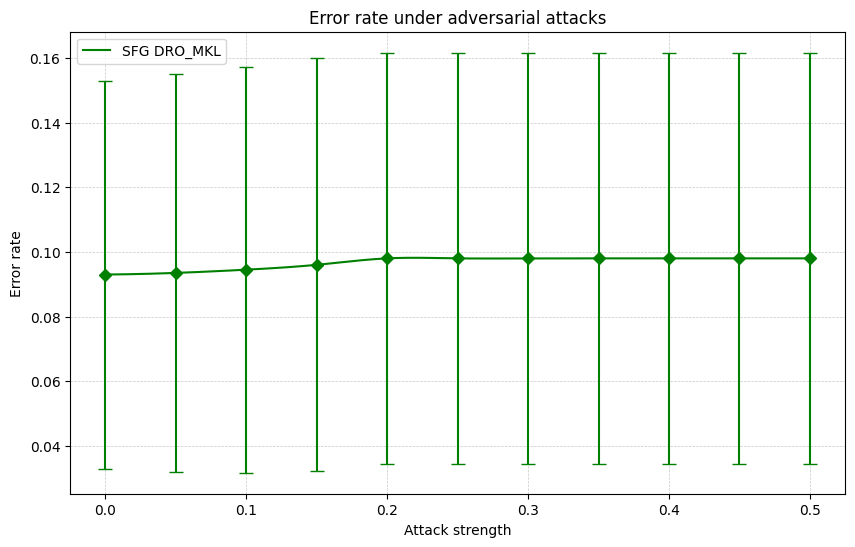

Error Rates under Adversarial Attacks:

Attack Strength	SFG DRO_MKL	
--------------------------------------------------
0.00			0.0930		
0.05			0.0935		
0.10			0.0945		
0.15			0.0960		
0.20			0.0980		
0.25			0.0980		
0.30			0.0980		
0.35			0.0980		
0.40			0.0980		
0.45			0.0980		
0.50			0.0980		


In [16]:

# Results for different models
results = [results_sfg_MKL]

# Corresponding labels for the legend
labels = ['SFG DRO_MKL']

# Colors for the plot lines
colors = ['green', ]

# Markers for the error bar
markers = ['D', 's']  # D is for diamond shape, s is for square shape

# Title for the plot
title = 'Error rate under adversarial attacks'

# Call the function to plot error rates
plot_error_rates(results, labels, colors, markers, title)
